# Molecular dynamics with franken and ASE

In this notebook we show how to perform MD with a trained franken model.
Once again we use the water dataset as a simple example, and finetune the [MACE-MP0 foundation model](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) which was trained on the materials-project dataset to accurately predict a potential field at a high level of theory.

In [1]:
try:
    import franken
except ImportError:
    %pip install franken[mace]
    import franken

In [9]:
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import ase
import ase.md
import ase.md.velocitydistribution
from ase.geometry.rdf import get_recommended_r_max, get_rdf

from franken.calculators.ase_calc import FrankenCalculator
from franken.datasets.registry import DATASET_REGISTRY
from franken.backbones.utils import CacheDir
from franken.autotune import autotune
from franken.config import (
    MaceBackboneConfig,
    MultiscaleGaussianRFConfig,
    DatasetConfig,
    SolverConfig,
    HPSearchConfig,
    AutotuneConfig,
)

In [3]:
import os
os.environ["FRANKEN_CACHE_DIR"] = "/leonardo_scratch/fast/IIT24_AtomSim/franken/franken_cache"

## Run autotune to train a franken model
The first step is to obtain a trained franken model, with which to perform the MD.

We do this using the `autotune` interface, for which [a dedicated tutorial](./autotune.ipynb) is available.

In [5]:
gnn_config = MaceBackboneConfig(
    path_or_id="MACE-L0",
    interaction_block=2,
)
dataset_cfg = DatasetConfig(name="water", max_train_samples=8)
rf_config = MultiscaleGaussianRFConfig(
    num_random_features=512,
    length_scale_low=10,
    length_scale_high=30,
    length_scale_num=4,
    rng_seed=42,  # for reproducibility
)
solver_cfg = SolverConfig(
    l2_penalty=HPSearchConfig(start=-10, stop=-5, num=5, scale='log'),  # equivalent of numpy.logspace
    force_weight=HPSearchConfig(start=0.01, stop=0.99, num=5, scale='linear'),  # equivalent of numpy.linspace
)
autotune_cfg = AutotuneConfig(
    dataset=dataset_cfg,
    solver=solver_cfg,
    backbone=gnn_config,
    rfs=rf_config,
    seed=42,
    jac_chunk_size=64,
    run_dir="./results",
)

In [6]:
run_path = autotune(autotune_cfg)

console_logging_level: INFO
dtype: float64
jac_chunk_size: 64
rf_normalization: leading_eig
run_dir: ./results
save_every_model: False
save_fmaps: False
scale_by_species: True
seed: 42
backbone:
    family: mace
    interaction_block: 2
    path_or_id: MACE-L0
dataset:
    max_train_samples: 8
    name: water
    test_path: null
    train_path: null
    val_path: null
rfs:
    length_scale_high: 30
    length_scale_low: 10
    length_scale_num: 4
    num_random_features: 512
    rf_type: multiscale-gaussian
    rng_seed: 42
    use_offset: true
solver:
    force_weight:
      num: 5
      scale: linear
      start: 0.01
      stop: 0.99
      value: null
      values: null
    l2_penalty:
      num: 5
      scale: log
      start: -10
      stop: -5
      value: null
      values: null

2025-04-29 13:05:57.596 INFO (rank 0): Initializing cache directory from $FRANKEN_CACHE_DIR /leonardo_scratch/fast/IIT24_AtomSim/franken/franken_cache
2025-04-29 13:05:57.696 INFO (rank 0): Run folder: 

ASE -> MACE (train):   0%|          | 0/8 [00:00<?, ?it/s]

ASE -> MACE (val):   0%|          | 0/189 [00:00<?, ?it/s]

Computing dataset statistics:   0%|          | 0/8 [00:00<?, ?it/s]

2025-04-29 13:06:26.852 WARNING (rank 0): `leading_eig` normalization has high memory usage. If you encounter OOM errors try to disable it.
2025-04-29 13:07:02.005 INFO (rank 0): Trial   1 | rf_type: multiscale-gaussian | num_random_features:   512   | length_scale_low:   10    | length_scale_high:   30    | length_scale_num:    4    | use_offset:  True   | rng_seed:   42    | Best trial 1 (energy 0.31 meV/atom - forces 25.0 meV/Ang)


## Run molecular dynamics

Next we can run the molecular dynamics simulation.

Most of the code below is boiler-plate for the simulation 

We start by defining some parameters of the molecular dynamics:
 - The MD length (in nanoseconds)
 - The timestep (in femtoseconds)
 - The simulation temperature (in kelvin)
 - Friction of the Langevin integrator (in units 1/fs)

In [26]:
md_length_ns = 0.01
timestep_fs = 0.5
temperature_K = 325
friction = 0.01
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Load the initial configuration: a random one taken from the water training set

In [27]:
data_path = DATASET_REGISTRY.get_path("water", "train", CacheDir.get())
initial_configuration = ase.io.read(data_path, index=567)

Initialize the `trajectory` object. It will be used to save the outputs of the MD.

In [28]:
md_path = run_path / "md"
md_path.mkdir(exist_ok=True)
# Trajectory will contain the output data
trajectory_path = md_path / f"md_output.traj"
trajectory = ase.io.Trajectory(trajectory_path, "w", initial_configuration)

Initialize the calculator object which wraps the `franken` model we have learned previously.

In [29]:
model_path = run_path / "best_ckpt.pt"
calc = FrankenCalculator(model_path, device=device)
initial_configuration.calc = calc

Initialize ASE-specific MD-related objects: 
 - the velocity initialization
 - the Langevin integrator 
 - and a logger to record results.

In [30]:
ase.md.velocitydistribution.MaxwellBoltzmannDistribution(
    atoms=initial_configuration,
    temperature_K=temperature_K
)
integrator = ase.md.Langevin(
    atoms=initial_configuration,
    temperature_K=temperature_K,
    friction=friction / ase.units.fs,
    timestep=timestep_fs * ase.units.fs
)
md_logger = ase.md.MDLogger(
    integrator,
    initial_configuration,
    sys.stdout,  # log directly to console
    header=True,
    stress=False,
    peratom=False,
)
integrator.attach(md_logger, interval=100)
integrator.attach(trajectory.write, interval=100)

Time[ps]      Etot[eV]     Epot[eV]     Ekin[eV]    T[K]


Finally run the MD for the desired number of time-steps

In [31]:
integrator.run(md_length_ns * 1e6 / timestep_fs)

0.0000         -916.283     -923.373        7.090   290.2
0.0500         -916.521     -923.713        7.192   294.4
0.1000         -915.770     -923.171        7.401   303.0
0.1500         -914.560     -923.485        8.925   365.3
0.2000         -914.554     -923.599        9.045   370.2
0.2500         -915.718     -923.643        7.924   324.4
0.3000         -915.394     -923.530        8.136   333.0
0.3500         -915.741     -923.415        7.674   314.1
0.4000         -916.037     -923.774        7.737   316.7
0.4500         -915.613     -923.570        7.957   325.7
0.5000         -915.735     -923.854        8.119   332.3
0.5500         -915.778     -923.393        7.615   311.7
0.6000         -915.919     -923.114        7.194   294.5
0.6500         -916.155     -924.523        8.368   342.5
0.7000         -916.692     -924.750        8.058   329.8
0.7500         -916.834     -924.706        7.871   322.2
0.8000         -916.360     -925.099        8.739   357.7
0.8500        

True

### Analyse MD results

The trajectory can be loaded with ASE, we can then plot the radial-distribution function of the simulation.

In [35]:
traj = ase.io.read(trajectory_path, index=":")
# Skip first time-step which is just the initial configuration
traj = traj[1:]
print(f"Loaded MD trajectory of length {len(traj)}")

Loaded MD trajectory of length 200


We compute the RDF of the O-O atoms within the trajectory, and then compute the average and plot it.
We're using ASE's `get_rdf` for the actual distance calculations.
The trajectory is very short, so the RDF is very noisy, but by increasing the simulation time it's easy to get a clean curve.

In [36]:
equilibration_fs = 0.5 * 100  # deliberately short
nbins_per_angstrom = 50

# Skip the beginning of the trajectory where simulation is not at equilibrium
traj_len_fs = timestep_fs * len(traj)
# equilibration time / 100 (sampling interval)
traj_eq = traj[int(equilibration_fs / timestep_fs / 100) :]

rmax = 6.3
nbins = int(rmax * nbins_per_angstrom)

element_pair = (8, 8)  # O-O distances

# Compute the average RDF
rdf_list = []
for i, atoms in enumerate(traj_eq):
    rdf, radii = get_rdf(
        atoms,
        rmax,
        nbins,
        no_dists=False,
        elements=element_pair,
    )
    rdf_list.append(rdf)
avg_rdf = np.mean(rdf_list, axis=0)

(1.5, 6.3)

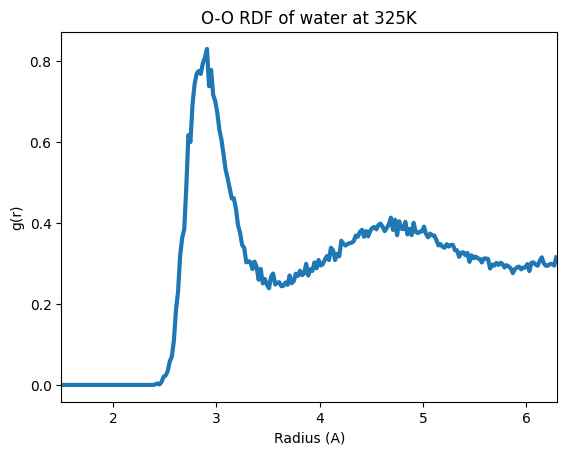

In [37]:
fig, ax = plt.subplots()
ax.plot(radii, avg_rdf, lw=3)
ax.set_xlabel("Radius (A)")
ax.set_ylabel("g(r)")
ax.set_title(f"O-O RDF of water at {temperature_K}K")
ax.set_xlim([1.5, rmax])